In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
import sklearn.feature_selection as sfs

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
# Log transform function
def log_transform(x):
    return np.log1p(x + 1e-6)

In [6]:
# Create pipeline
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(log_transform)),
    ('pca', PCA(n_components=11)),
    #("fs", sfs.SelectKBest(sfs.f_classif, k=50)),
    #('svm', SVC(kernel='linear'),
    ('svm', SVC(kernel="rbf"),
    #('svm', SVC(kernel="sigmoid"),
    )
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)
loo = LeaveOneOut()

In [7]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#008C8D','white','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [8]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 14
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).mean().reset_index()
df_female = sample.copy()
df_female.rename(columns={'binned_age': 'age'}, inplace=True)
df_female.set_index(['age', 'mouse'], inplace=True)

In [9]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 14
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).mean().reset_index()
df_male=sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [10]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [11]:
## joint data
#m_data=m_norm.copy()
m_data=m_df.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

#f_data=f_norm.copy()
f_data=f_df.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

In [12]:
data=pd.concat([m_data,f_data])

In [13]:
df=data.copy()
# choose a model for decoder
clf = SVC(kernel='linear') 
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

In [14]:
age2=[]
acc=[]
n=10
#n=16
for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        age2.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        #acc.append(np.mean(cross_val_score(clf, x, y, cv=cv, n_jobs=-1)))
        #acc.append(np.mean(cross_val_score(pipeline, x, y, cv=stratified_kfold, n_jobs=-1)))
        acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))
        #acc.append(np.mean(cross_val_score(pipeline, x, y, cv=loo, n_jobs=-1)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:19<00:00,  9.20s/it]


In [15]:
# create df for plotting
df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

In [16]:
df.acc.mean()

0.8322452000000001

In [17]:
df=data.copy()

In [18]:
sh_ages=[]
sh_acc=[]

for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        sh_ages.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        y = y.to_series().sample(frac=1, random_state=i).values
        #sh_acc.append(np.mean(cross_val_score(clf, x, y, cv=cv, n_jobs=-1)))
        sh_acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:35<00:00,  9.36s/it]


In [19]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

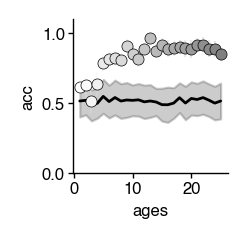

In [20]:
format_plots()
fig, ax = plt.subplots(figsize=(1, 1))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 1))
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=4,
              palette = cma,
              hue='ages',
              linestyle='-',
              markeredgecolor='black', 
              markeredgewidth=0.25,
              estimator='mean', 
              errorbar=('sd',1),
            legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
#plt.xticks([0, 10, 20, 30, 40, 50])
sns.despine()


In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_sex_decoder_svm_longv2_pca_sigmoid_2WEEKS.pdf', bbox_inches='tight')

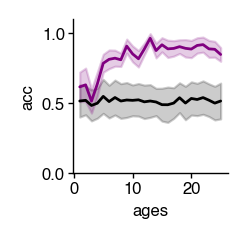

In [22]:
fig, ax = plt.subplots(figsize=(1, 1))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 1))
sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='purple', estimator='mean', errorbar=('sd', 1))
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
#plt.xticks([2,5,10,15,20,25,30,35,])
sns.despine()


In [23]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_sex_decoder_svm_longv2_pca_rbf_2WEEKS_line.pdf', bbox_inches='tight')